## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# # save model checkpoints
# !mkdir ./ckpts

# !kaggle datasets download -d samfc10/vesuvius-zarr-files

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os,cv2
import gc
import sys
import random
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

# sys.path.append("/kaggle/input/resnet3d")
ROOT_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection/'
sys.path.append(ROOT_DIR)
from resnet3d import generate_model

### Config

In [3]:
class CFG:
    DATA_DIR = ROOT_DIR
    # DATA_DIR = "/kaggle/input/vesuvius-zarr-files/"
    LR = 1e-4
    EPOCHS = 30
    BATCH_SIZE = 64
    NUM_WORKERS = 8
    CROP_SIZE = 224
    Z_LIST = list(range(0, 48, 4))
    TRAIN_FRAGMENTS = ["1", "3"]
    TEST_FRAGMENT = "2"
    MODEL_DEPTH = 34
    MAX_PIXEL_VALUE = 2 ** 16 - 1
    RESIZE_HEIGHT = 4800
    COMP_DATASET_PATH = "/home/fummicc1/codes/competitions/kaggle-ink-detection/"
    
    
    Z_START = Z_LIST[0]    
    Z_DIM = len(Z_LIST)

### Load data

In [4]:
def resize(img):
    return img
    current_height, current_width = img.shape[:2]
    aspect_ratio = current_width / current_height
    new_height = RESIZE_HEIGHT
    new_width = int(new_height * aspect_ratio)
    new_size = (new_width, new_height)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

In [5]:
def load_mask(split, index):
    img = cv2.imread(f"{CFG.DATA_DIR}/{split}/{index}/mask.png", 0) // 255    
    img = resize(img)    
    return img

def load_labels(split, index):
    img = cv2.imread(f"{CFG.DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img

In [6]:
def calculate_mean_std(volume):
    # mean_0 = np.mean(volume / 255, axis=0)
    # mean_1 = np.mean(mean_0, axis=0)
    # std_0 = np.std(volume / 255, axis=0)
    # std_1 = np.std(std_0, axis=0)
    mean_1 = np.array([0.45 for i in range(CFG.Z_DIM)])
    std_1 = np.array([0.225 for i in range(CFG.Z_DIM)])
    return mean_1, std_1


In [7]:
def read_image(mode, fragment_id):
    images = []

    # idxs = range(65)
    start = 0
    end = 65
    idxs = range(start, end)

    for i in tqdm(idxs):
        image = cv2.imread(CFG.COMP_DATASET_PATH + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", -1)
        # image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)
        
        # print(image.max())
        image = resize(image).astype(np.float32)     
        # print(image.max())

        # pad0 = (CROP_SIZE - image.shape[0] % CROP_SIZE)
        # pad1 = (CROP_SIZE - image.shape[1] % CROP_SIZE)

        # image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
        # print(image.max())
        images.append(image)
    images = np.stack(images, axis=2, dtype=np.float32)
    # print(images.max())
    return images

In [8]:
FRAGMENTS_ZARR = {
    "1" : {},
    "2" : {},
    "3" : {},
}


In [9]:

for key in ["1", "2", "3"]:
    FRAGMENTS_ZARR[key]["surface_volume"] = read_image("train", key)
    FRAGMENTS_ZARR[key]["mask"] = load_mask("train", key)
    FRAGMENTS_ZARR[key]["truth"] = load_labels("train", key)

100%|██████████| 65/65 [00:05<00:00, 12.91it/s]


In [10]:
FRAGMENTS_SHAPE = {k : v["surface_volume"].shape[:-1] for k, v in FRAGMENTS_ZARR.items()}

In [11]:

ALL_MEAN_STD = {}
img = FRAGMENTS_ZARR["1"]["surface_volume"][:, :, CFG.Z_START:CFG.Z_START+CFG.Z_DIM]
mean, std = calculate_mean_std(img)
for key in ["1", "2", "3"]:    
    ALL_MEAN_STD[key] = mean, std
    

In [12]:
mean, std = ALL_MEAN_STD["2"]
mean, std

(array([0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45,
        0.45]),
 array([0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225, 0.225,
        0.225, 0.225, 0.225]))

In [13]:
list(FRAGMENTS_ZARR["1"].keys())
# np.unique(np.array(FRAGMENTS_ZARR["1"]["surface_volume"]))

['surface_volume', 'mask', 'truth']

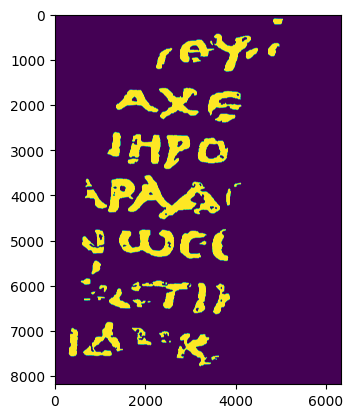

In [14]:
plt.imshow(FRAGMENTS_ZARR["1"]["truth"])

In [15]:
def fetch_fragment_crop(id: str, y1, y2, x1, x2, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2, z1:z2]
        return img.astype(np.float32)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2]
        return img.astype(np.uint8)
    print("Error", key)

def fetch_fragment(id: str, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][:, :, z1:z2]
        return img.astype(np.float32)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key]
        return img.astype(np.uint8)

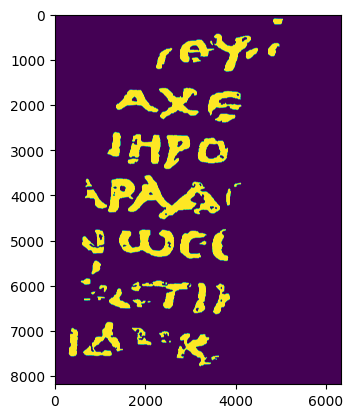

In [16]:
plt.imshow(FRAGMENTS_ZARR["1"]["truth"][:,:])

### Visualise input

In [17]:
fragment_id = FRAGMENTS_ZARR["1"]
x, y = 3000, 4000

# np.unique(FRAGMENTS_ZARR["1"]["surface_volume"][y:y+CROP_SIZE, x:x+CROP_SIZE, :])
fragment_cropped = fetch_fragment_crop("1", y, y+CFG.CROP_SIZE, x, x+CFG.CROP_SIZE, CFG.Z_START, CFG.Z_START+CFG.Z_DIM)
imageio.mimwrite("fragment_crop.mp4", (fragment_cropped.transpose(2, 0, 1) / 255), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.


(-0.5, 223.5, 223.5, -0.5)

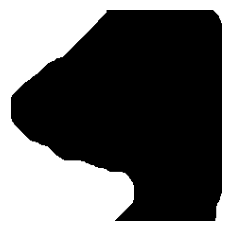

In [18]:
mask_cropped = fragment_id["truth"][y:y+CFG.CROP_SIZE, x:x+CFG.CROP_SIZE]
# ir_cropped = fragment_id["infrared"][y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(ir_cropped, cmap="gray")
# plt.axis("off")
# plt.show()

In [19]:
# del fragment_id, fragment_cropped, mask_cropped, ir_cropped
# gc.collect()

### Dataloaders

In [20]:

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment_id in fragments:
            H, W = FRAGMENTS_SHAPE[fragment_id]
            for y in range(0, H-CFG.CROP_SIZE+1, CFG.CROP_SIZE):
                for x in range(0, W-CFG.CROP_SIZE+1, CFG.CROP_SIZE):
                    self.xys.append((fragment_id, x, y, W, H))
        
    def __getitem__(self, i):
        fragment_id, x1, y1, W, H = self.xys[i]
        z1, z2 = CFG.Z_START, CFG.Z_START + CFG.Z_DIM
        
        x2 = x1 + CFG.CROP_SIZE
        y2 = y1 + CFG.CROP_SIZE
            
        # print("x1: ", x1, " x2: ", x2, " y1: ", y1, " y2: ", y2)
        
        frag_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, z1, z2)
        label_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]
        
        frag_crop /= (2 ** 16 - 1)
                                                
        performed = A.Compose([
            A.HorizontalFlip(p=0.2), # 水平方向に反転
            A.VerticalFlip(p=0.2), # 水平方向に反転
            A.RandomScale(p=0.2),
            A.RandomRotate90(p=0.2),
            # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
            # A.CoarseDropout(
            #     max_holes=1,
            #     max_width=int(CROP_SIZE * 0.1), 
            #     max_height=int(CROP_SIZE * 0.1), 
            #     mask_fill_value=0,
            #     p=0.3
            # ),
            A.ShiftScaleRotate(p=0.2),
            A.Resize(height=CFG.CROP_SIZE, width=CFG.CROP_SIZE),
        ])(image=frag_crop, mask=label_crop)
        frag_crop = performed["image"]        
        label_crop = performed["mask"]
        
        frag_crop = frag_crop.astype(np.float16)
        
        # print("frag_crop", frag_crop[100, 100, :])
        
        mean, std = ALL_MEAN_STD[fragment_id]
        frag_crop = (frag_crop - mean) / std
        # print("frag_crop after norm", frag_crop[100, 100, :])
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        label_crop = torch.from_numpy(label_crop.astype(np.float32)).permute(2, 0, 1)
        
        assert frag_crop.shape[0] == len(CFG.Z_LIST)
        
        return {
            "images": frag_crop,
            "labels": label_crop
        }

    def __len__(self):
        return len(self.xys)

In [21]:
ALL_MEAN_STD["1"][0].shape, ALL_MEAN_STD["1"][1].shape

((12,), (12,))

In [22]:
class VesuviusVal(Dataset):
    def __init__(self, fragment_id):
        self.fragment_id = fragment_id
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment_id]
        for y in range(0, H-CFG.CROP_SIZE+1, CFG.CROP_SIZE):
            for x in range(0, W-CFG.CROP_SIZE+1, CFG.CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CFG.CROP_SIZE, y1+CFG.CROP_SIZE
        z1, z2 = CFG.Z_START, CFG.Z_START + CFG.Z_DIM
        
        frag_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, z1, z2)
        
        label_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]
        
        frag_crop = frag_crop / 255.0 / 255.0

        mean, std = ALL_MEAN_STD[self.fragment_id]
        
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        label_crop = torch.from_numpy(label_crop.astype(np.float32)).permute(2, 0, 1)
        
        assert frag_crop.shape[0] == len(CFG.Z_LIST)
        
        return {
            "images": frag_crop,
            "labels": label_crop,
            "locations": torch.tensor([x1, y1, x2, y2], dtype=torch.int32)
        }

    def __len__(self):
        return len(self.xys)

In [23]:
def collate_train_fn(batch):
  return {
      'images': torch.stack([x['images'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch])
}
  
  
def collate_val_fn(batch):
  return {
      'images': torch.stack([x['images'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch]),
      'locations': torch.stack([x['locations'] for x in batch])
}

In [24]:
dataset_train = VesuviusTrain(CFG.TRAIN_FRAGMENTS)
dataloader_train = DataLoader(
    dataset_train, 
    batch_size=CFG.BATCH_SIZE, 
    num_workers=CFG.NUM_WORKERS,
    collate_fn=collate_train_fn,
    shuffle=True
)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(CFG.TEST_FRAGMENT)
dataloader_valid = DataLoader(
    dataset_valid, 
    batch_size=CFG.BATCH_SIZE, 
    num_workers=CFG.NUM_WORKERS,
    collate_fn=collate_val_fn,
    shuffle=False
)
n_valid = len(dataloader_valid)

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [25]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=CFG.MODEL_DEPTH):
        super().__init__()
        self.encoder = generate_model(model_depth=CFG.MODEL_DEPTH, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None] # チャネルを追加
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
        
   
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder=SegModel()
        weight_path = "r3d18_K_200ep.pth"
        if os.path.exists(weight_path):
            self.encoder.load_pretrained_weights(torch.load(weight_path)["state_dict"])

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        # images=normalization(images)
        output = self.encoder(images)
        return output

In [26]:
model = CustomModel()
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model = model.cuda()

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

### Competition metric (F0.5 Score)

In [27]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [31]:
scaler = amp.GradScaler()
TverskyLoss = smp.losses.TverskyLoss(mode='binary')
BCELoss = nn.BCEWithLogitsLoss()
DiceLoss = smp.losses.DiceLoss(mode="binary", smooth=1e-6)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=4)

def criterion(pred,target):
    return BCELoss(pred, target)

In [32]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[CFG.TEST_FRAGMENT]["truth"])).float().cuda()
gt_shape = FRAGMENTS_SHAPE[CFG.TEST_FRAGMENT]

In [33]:
for epoch in range(1, CFG.EPOCHS+1):
    model.train()
    cur_lr = optimizer.param_groups[0]['lr']
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    for i, batches in pbar_train:
        fragments = batches["images"]
        labels = batches["labels"]
        fragments, labels = fragments.cuda(), labels.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))    
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, batches in pbar_val:
        fragments = batches["images"]
        labels = batches["labels"]
        xys = batches["locations"]
        fragments, labels = fragments.cuda(), labels.cuda()
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, labels).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    model.train()
    scheduler.step(metrics=mloss_val)
    
    for threshold in np.arange(0.2, 0.65, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
    
    if epoch % 10 == 0:
        torch.save(model.module.state_dict(), f"./ckpts/resnet{CFG.MODEL_DEPTH}_val_{CFG.TEST_FRAGMENT}_3d_seg_epoch_{epoch}.pt")

    if epoch == 30:
        break

Epoch 1/30  Mem : 9.83GB      0.0001  Loss: 0.7929:  25%|██▌       | 7/28 [00:02<00:06,  3.06it/s]